In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pwd

/content


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt

In [ ]:
# veriler yukle
file_path = "/content/drive/MyDrive/Data Analyts Project/sensor_288_temizlenmis.xlsx"
trafik_df = pd.read_excel(file_path)
file_path ="/content/drive/MyDrive/Data Analyts Project/Akaryakit_temizlenmis1.xlsx"
yakit_df = pd.read_excel(file_path)

In [ ]:
# Tarih sutunleri datetime formatina cevir cunku 2 dosyada tarihler farkli tipi oldugu icin
trafik_df["Tarih"] = pd.to_datetime(trafik_df["Tarih"])
yakit_df["Tarih"] = pd.to_datetime(yakit_df["Tarih"])
# birleştirme yap
df = pd.merge(trafik_df, yakit_df, on="Tarih", how="inner") #how="inner"sadece her iki tabloda da bulunan tarihler kalacak (kesişim).

In [ ]:
# Convert 'V/Max Kurşunsuz 95' to numeric
df["V/Max Kurşunsuz 95"] = df["V/Max Kurşunsuz 95"].astype(str).str.replace(" TL/LT", "")
df["V/Max Kurşunsuz 95"] = df["V/Max Kurşunsuz 95"].astype(float)

# Calculate the daily percentage change in fuel price
df['Fiyat_Degisim'] = df['V/Max Kurşunsuz 95'].pct_change()

# Create a boolean column indicating if there was a price increase (Zam)
df['Zam_var_mi'] = df['Fiyat_Degisim'] > 0

# Filter for the dates with price increases
zam_tarihleri = df.loc[df["Zam_var_mi"], "Tarih"]

In [ ]:
output_path = "/content/drive/MyDrive/Data Analyts Project/zam_tarihleri.xlsx"
zam_tarihleri.to_excel(output_path, index=False)
print(f"Sonuçlar Excel'e kaydedildi: {output_path}")

Sonuçlar Excel'e kaydedildi: /content/drive/MyDrive/Data Analyts Project/zam_tarihleri.xlsx


In [ ]:
#  Mann-Whitney U testi ---
sonuclar = []
for tarih in zam_tarihleri:
    once = df[(df['Tarih'] < tarih) & (df['Tarih'] >= tarih - pd.Timedelta(days=7))]['ARAC TOPLAM']
    sonra = df[(df['Tarih'] > tarih) & (df['Tarih'] <= tarih + pd.Timedelta(days=7))]['ARAC TOPLAM']

    if len(once) > 0 and len(sonra) > 0:
        u_stat, p_val = mannwhitneyu(once, sonra, alternative='two-sided')
        sonuclar.append({
            "Tarih": tarih.date(),
            "Önce Ortalama": round(once.mean(), 2),
            "Sonra Ortalama": round(sonra.mean(), 2),
            "Mann-Whitney p": round(p_val, 4)
        })

In [ ]:
# Sonuçları tabloya dök ---
df_sonuc = pd.DataFrame(sonuclar)
print(df_sonuc.head())

        Tarih  Önce Ortalama  Sonra Ortalama  Mann-Whitney p
0  2022-01-06       99427.60        97053.20          0.8413
1  2022-01-08      101197.57        96480.20          0.2677
2  2022-01-13       98875.00        98730.86          0.6389
3  2022-01-20       98914.29        70128.57          0.0041
4  2022-02-02       91946.43        94587.29          0.9015


In [ ]:
# --- 7. Excel olarak kaydet ---
output_path = "/content/drive/MyDrive/Data Analyts Project/mannwhitney_sonuclar.xlsx"
df_sonuc.to_excel(output_path, index=False)
print(f"Sonuçlar Excel'e kaydedildi: {output_path}")

Sonuçlar Excel'e kaydedildi: /content/drive/MyDrive/Data Analyts Project/mannwhitney_sonuclar.xlsx


In [ ]:
sonuc_df = pd.read_excel("/content/drive/MyDrive/Data Analyts Project/mannwhitney_sonuclar.xlsx")

In [ ]:
anlamli = sonuc_df[sonuc_df["Mann-Whitney p"] < 0.05]
print("Anlamlı çıkan zam günleri:")
print(anlamli)

Anlamlı çıkan zam günleri:
        Tarih  Önce Ortalama  Sonra Ortalama  Mann-Whitney p
3  2022-01-20       98914.29        70128.57          0.0041
5  2022-02-09       93146.00        99921.00          0.0262
8  2022-03-04      100922.43        83977.57          0.0262
9  2022-03-05      101293.71        81770.83          0.0350
16 2022-05-18       93687.00       101797.17          0.0238
17 2022-05-20       89509.67        99505.14          0.0167
34 2022-10-28       94248.57       100638.86          0.0379


In [ ]:
output_path = "/content/drive/MyDrive/Data Analyts Project/Anlamlı çıkan zam günleri.xlsx"
anlamli.to_excel(output_path, index=False)
print(f"Sonuçlar Excel'e kaydedildi: {output_path}")

Sonuçlar Excel'e kaydedildi: /content/drive/MyDrive/Data Analyts Project/Anlamlı çıkan zam günleri.xlsx


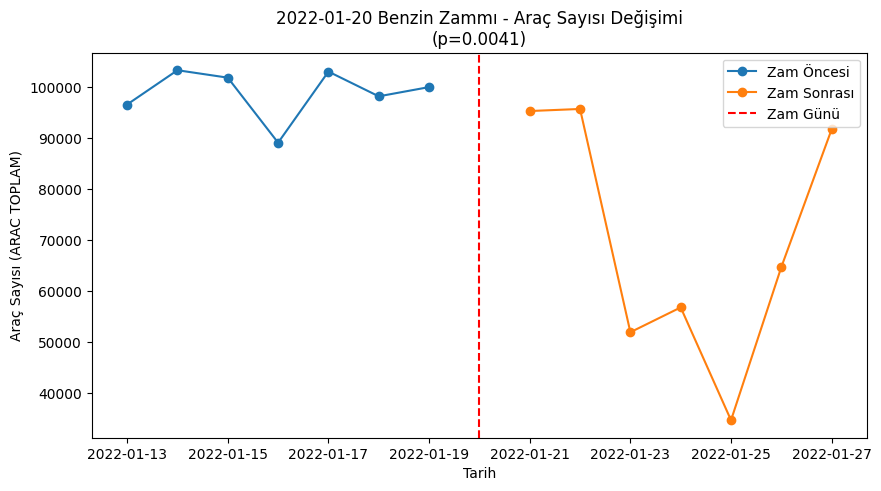

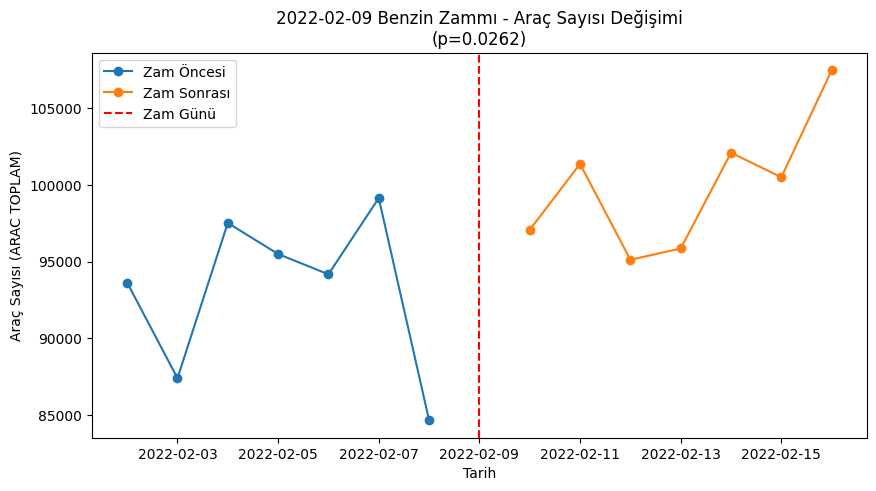

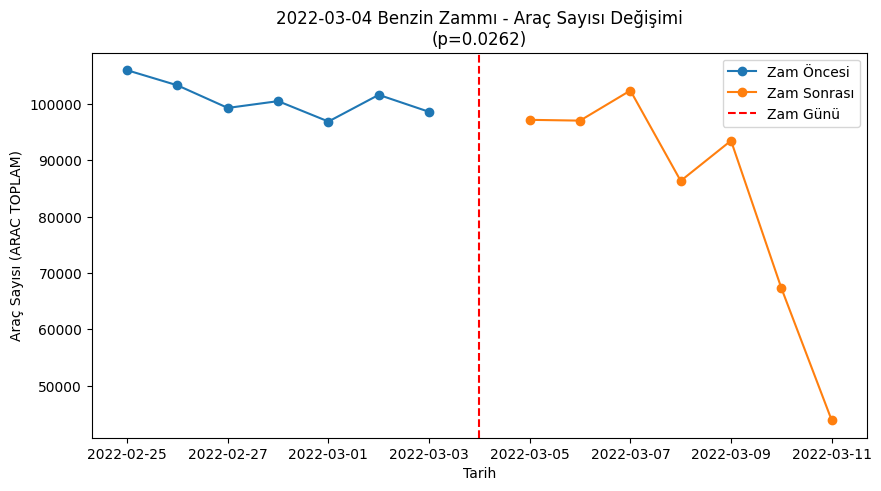

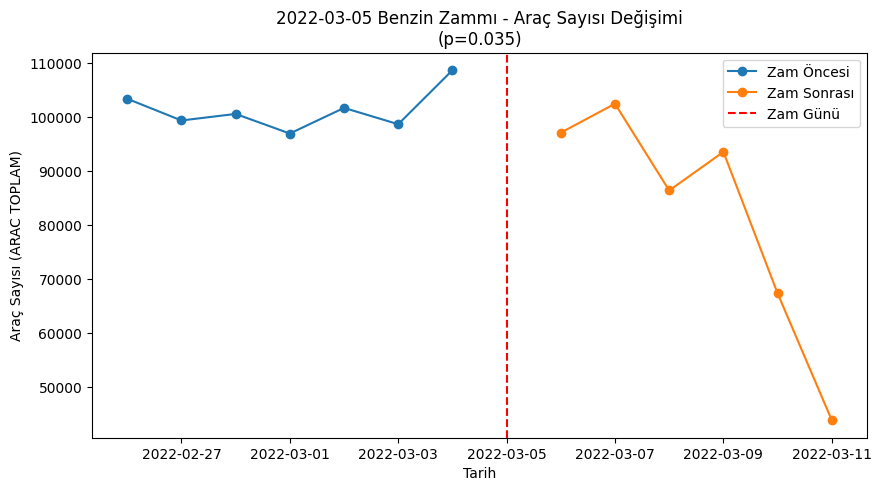

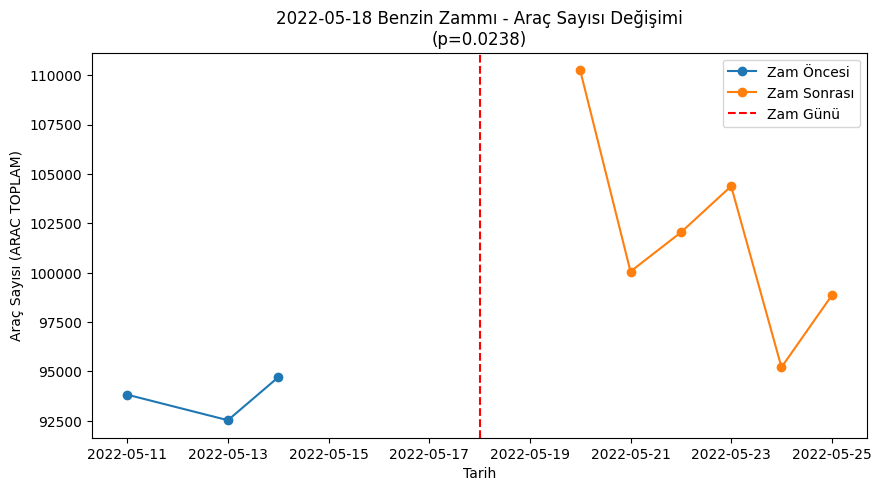

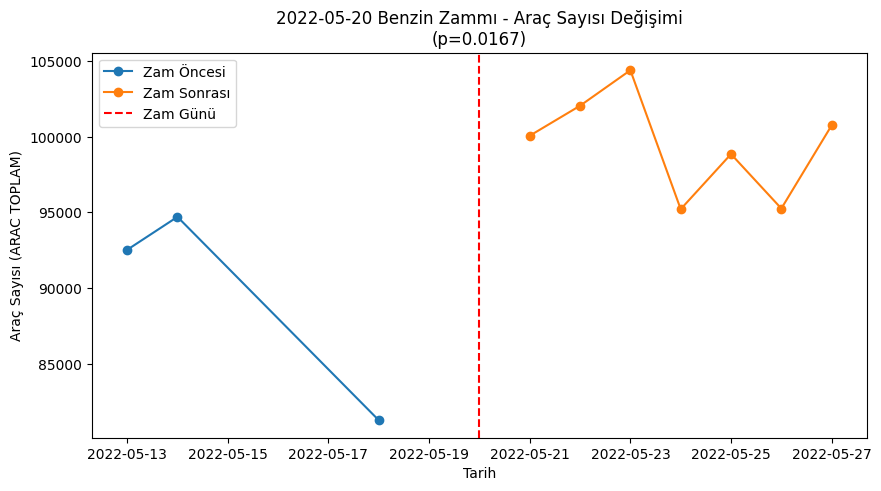

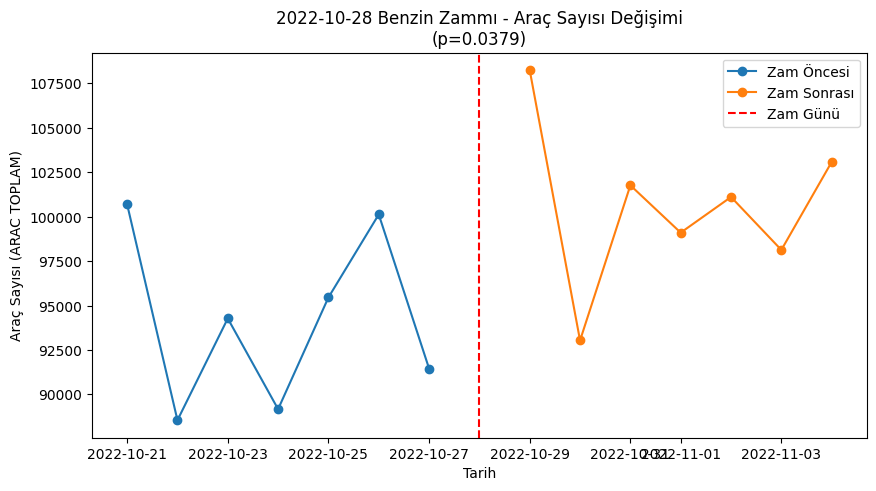

In [ ]:
#Grafik çizdir (her anlamlı zam günü için)
for _, row in anlamli.iterrows():
    zam_tarihi = pd.to_datetime(row["Tarih"])
    once = df[(df['Tarih'] < zam_tarihi) & (df['Tarih'] >= zam_tarihi - pd.Timedelta(days=7))]
    sonra = df[(df['Tarih'] > zam_tarihi) & (df['Tarih'] <= zam_tarihi + pd.Timedelta(days=7))]

    plt.figure(figsize=(10,5))
    plt.plot(once['Tarih'], once['ARAC TOPLAM'], marker='o', label='Zam Öncesi')
    plt.plot(sonra['Tarih'], sonra['ARAC TOPLAM'], marker='o', label='Zam Sonrası')
    plt.axvline(zam_tarihi, color='red', linestyle='--', label='Zam Günü')
    plt.legend()
    plt.title(f"{zam_tarihi.date()} Benzin Zammı - Araç Sayısı Değişimi\n(p={row['Mann-Whitney p']})")
    plt.xlabel("Tarih")
    plt.ylabel("Araç Sayısı (ARAC TOPLAM)")
    plt.show()